<a href="https://colab.research.google.com/github/Soufia99/SoufiaInoussa/blob/main/Sleep_data_Final_Project_545.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GOAL: we aim to
uncover the relationship between various lifestyle factors and sleep outcomes. We hope to identify which variables have the most
significant impact on sleep quality

In [ ]:
#Import numpy / pandas

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from sklearn import datasets


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Number of clusters & Evaluation
from sklearn.metrics import silhouette_score, f1_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
print("\nDataset shape (rows, columns):")
df.shape


Dataset shape (rows, columns):


(374, 13)

In [ ]:
df.head(374)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


Showing what type of variables we have below to make sense of why we standarized.

In [ ]:
print("\nData info:")
df.info()


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


## Data Visualization: Before Cleaning and Standardization

Visualize the distributions of key numerical and categorical features in their raw form to understand the dataset's initial state and identify any obvious patterns, outliers, or imbalances.

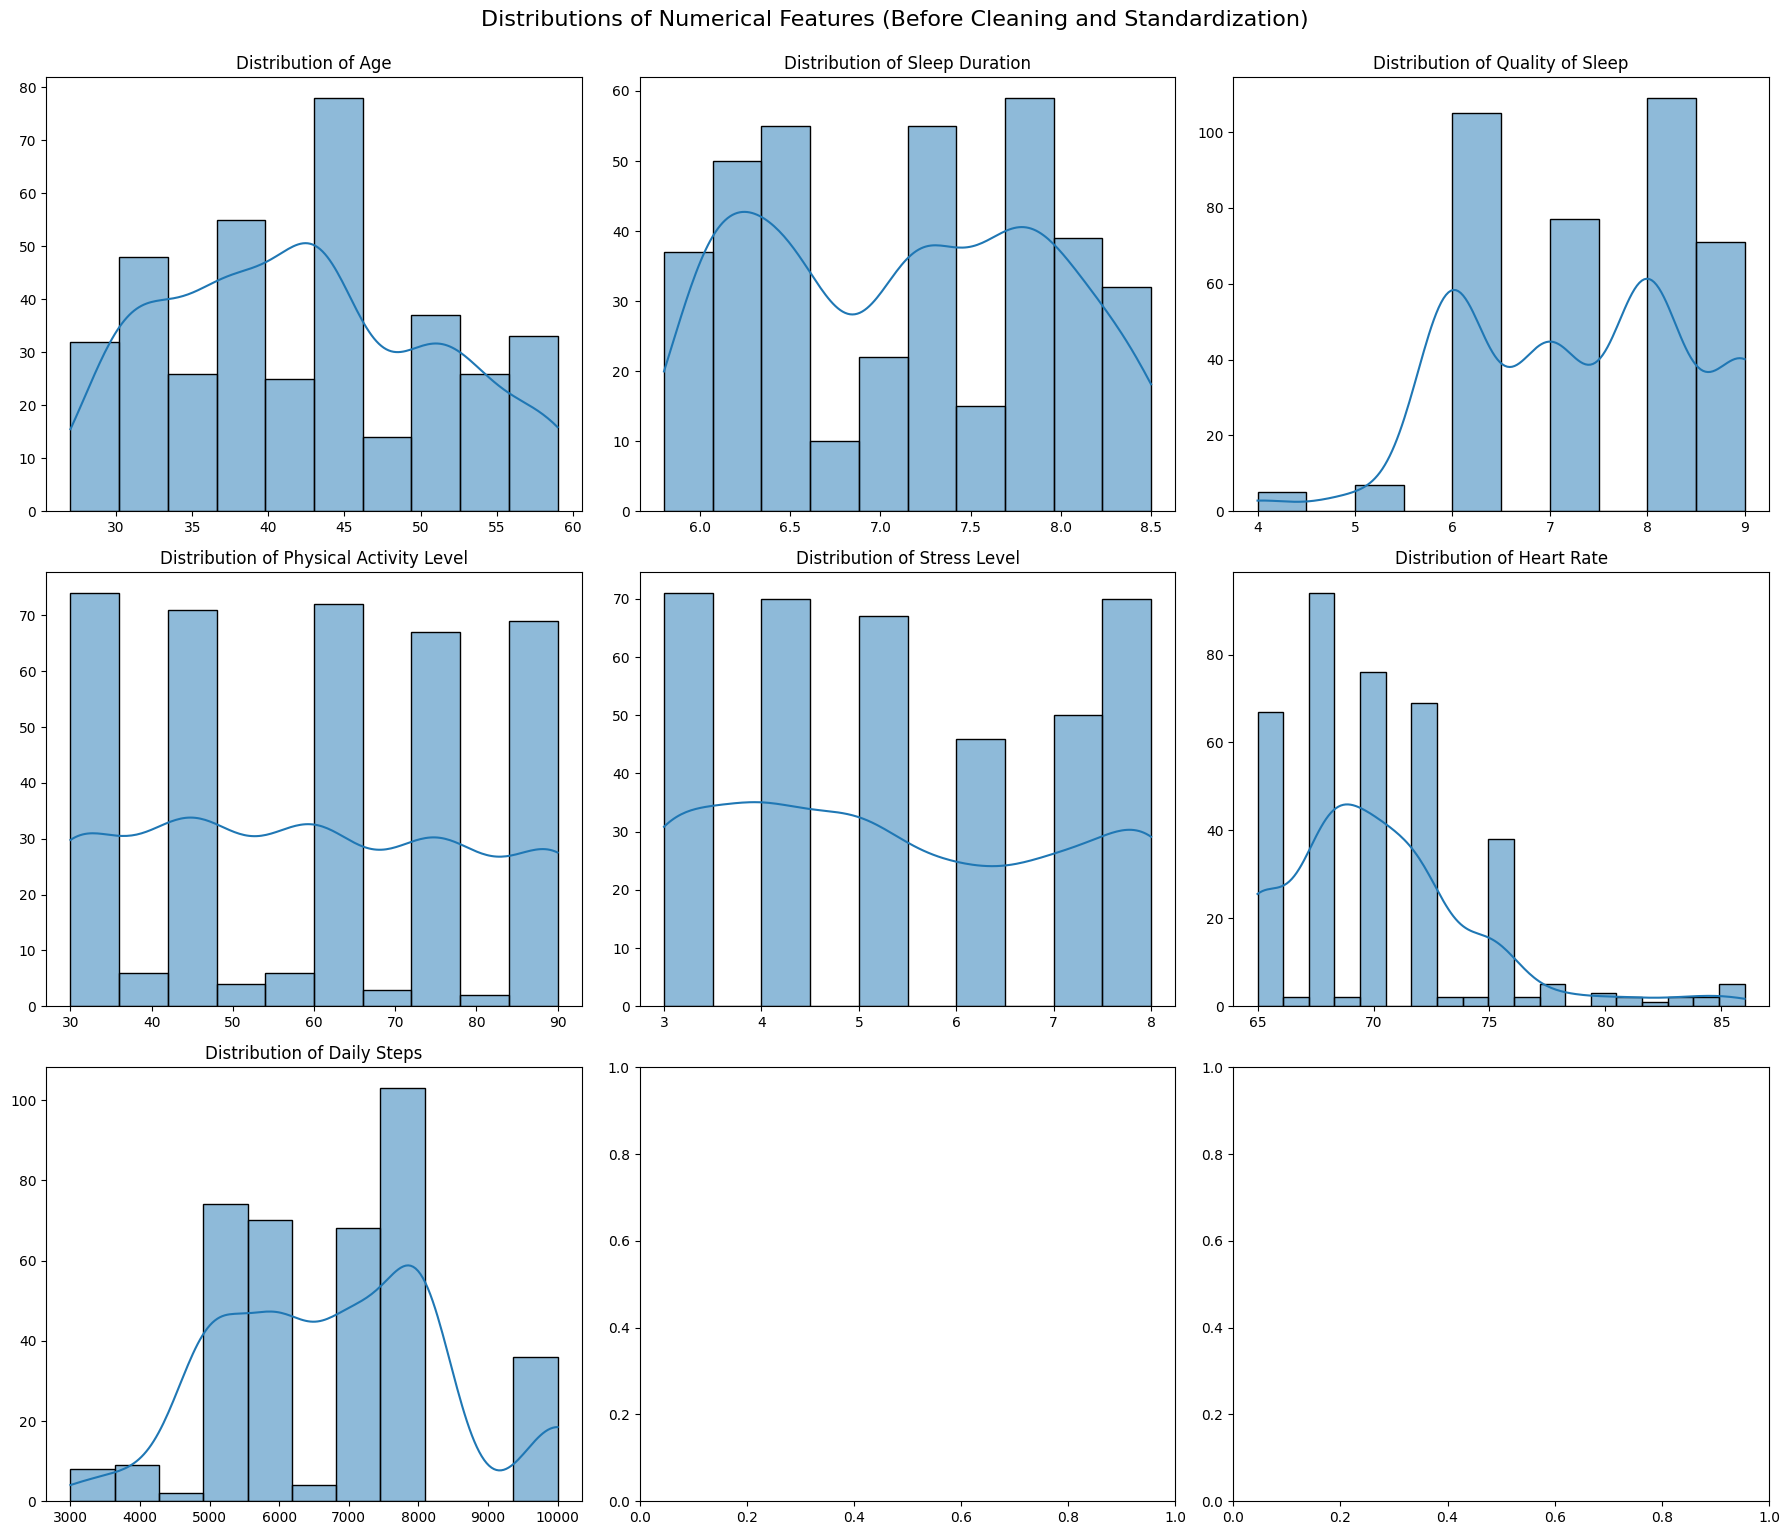

In [ ]:
# Visualize distributions of numerical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()
numerical_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.suptitle('Distributions of Numerical Features (Before Cleaning and Standardization)', y=1.02, fontsize=16)
plt.show()

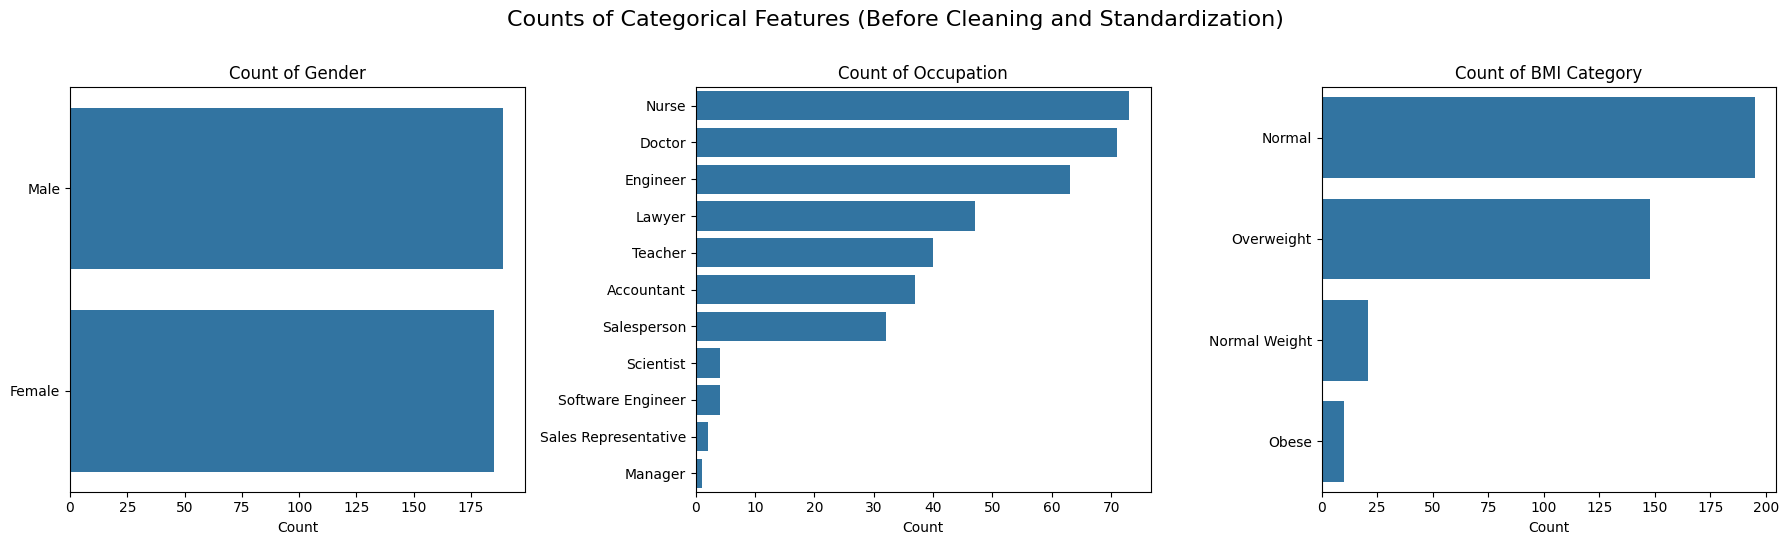

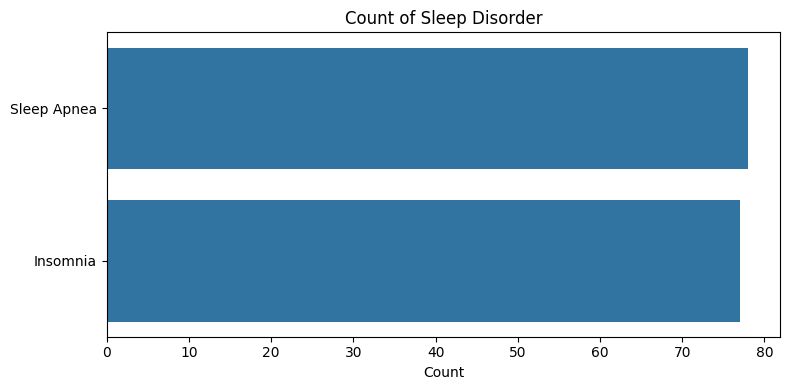

In [ ]:
# Visualize count plots for categorical features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
axes = axes.flatten()
categorical_cols = ['Gender', 'Occupation', 'BMI Category'] # Exclude 'Sleep Disorder' for now

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        sns.countplot(y=df[col], ax=axes[i], order=df[col].value_counts().index)
        axes[i].set_title(f'Count of {col}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel('')
    else:
        axes[i].axis('off') # Turn off axis if column not found

plt.tight_layout()
plt.suptitle('Counts of Categorical Features (Before Cleaning and Standardization)', y=1.08, fontsize=16)
plt.show()

# Count plot for the target variable 'Sleep Disorder'
plt.figure(figsize=(8, 4))
sns.countplot(y=df['Sleep Disorder'], order=df['Sleep Disorder'].value_counts().index)
plt.title('Count of Sleep Disorder')
plt.xlabel('Count')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
target = 'Sleep Disorder'
# Drop rows where the target variable is NaN to avoid issues with stratify
# Using .copy() to avoid SettingWithCopyWarning
Sleep_health_processed = df.dropna(subset=[target]).copy()

# --- Feature Engineering for non-numeric columns ---

# 1. Handle 'Blood Pressure' column
# Split 'Blood Pressure' into two numerical columns: Systolic and Diastolic
Sleep_health_processed[['Systolic Pressure', 'Diastolic Pressure']] = Sleep_health_processed['Blood Pressure'].str.split('/', expand=True)
Sleep_health_processed['Systolic Pressure'] = pd.to_numeric(Sleep_health_processed['Systolic Pressure'])
Sleep_health_processed['Diastolic Pressure'] = pd.to_numeric(Sleep_health_processed['Diastolic Pressure'])

# Drop the original 'Blood Pressure' column
Sleep_health_processed = Sleep_health_processed.drop('Blood Pressure', axis=1)

# 2. Handle 'BMI Category' column (Categorical)
# Apply one-hot encoding to 'BMI Category'
# Use drop_first=True to avoid multicollinearity for logistic regression
Sleep_health_processed = pd.get_dummies(Sleep_health_processed, columns=['BMI Category'], drop_first=True, dtype=int)

# --- Define the final features list for X ---
# Start with the numerical columns that didn't need splitting/encoding
numerical_features = ['Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']

# Add the newly created numerical 'Blood Pressure' components
bp_features = ['Systolic Pressure', 'Diastolic Pressure']

# Add the one-hot encoded 'BMI Category' columns dynamically
bmi_category_features = [col for col in Sleep_health_processed.columns if col.startswith('BMI Category_')]

# Combine all final features
final_features = numerical_features + bp_features + bmi_category_features

# Now, create X and y with the processed features
X = Sleep_health_processed[final_features]
y = Sleep_health_processed[target]



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Extract the feature names from sorted_selected_features
selected_feature_names = [feature for feature, coef in sorted_selected_features]

# 2. Create a new DataFrame X_selected using only these features
X_selected = X[selected_feature_names]

# 3. Instantiate a LabelEncoder object. Fit and transform the original target variable y
le_selected = LabelEncoder()
y_selected_encoded = le_selected.fit_transform(y)
print(f"Original target labels: {le_selected.classes_}")

# 4. Split X_selected and the original y into training and testing sets
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_selected, y, test_size=0.3, random_state=1, stratify=y)

# 5. Split X_selected and the encoded target y_selected_encoded into training and testing sets
X_train_selected_encoded, X_test_selected_encoded, y_train_selected_encoded, y_test_selected_encoded = train_test_split(
    X_selected, y_selected_encoded, test_size=0.3, random_state=1, stratify=y_selected_encoded)

# 6. Standardize the first split (for original y)
scaler_selected = StandardScaler()
X_train_selected_std = scaler_selected.fit_transform(X_train_selected)
X_test_selected_std = scaler_selected.transform(X_test_selected)

# 7. Standardize the second split (for encoded y)
scaler_selected_encoded = StandardScaler()
X_train_selected_encoded_std = scaler_selected_encoded.fit_transform(X_train_selected_encoded)
X_test_selected_encoded_std = scaler_selected_encoded.transform(X_test_selected_encoded)

# 8. Print the shapes of all created training and testing feature sets and target variables
print("\nShapes of prepared data:")
print(f"X_train_selected_std shape: {X_train_selected_std.shape}")
print(f"X_test_selected_std shape: {X_test_selected_std.shape}")
print(f"y_train_selected shape: {y_train_selected.shape}")
print(f"y_test_selected shape: {y_test_selected.shape}")
print(f"X_train_selected_encoded_std shape: {X_train_selected_encoded_std.shape}")
print(f"X_test_selected_encoded_std shape: {X_test_selected_encoded_std.shape}")
print(f"y_train_selected_encoded shape: {y_train_selected_encoded.shape}")
print(f"y_test_selected_encoded shape: {y_test_selected_encoded.shape}")

Original target labels: ['Insomnia' 'Sleep Apnea']

Shapes of prepared data:
X_train_selected_std shape: (108, 6)
X_test_selected_std shape: (47, 6)
y_train_selected shape: (108,)
y_test_selected shape: (47,)
X_train_selected_encoded_std shape: (108, 6)
X_test_selected_encoded_std shape: (47, 6)
y_train_selected_encoded shape: (108,)
y_test_selected_encoded shape: (47,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- Step: Dedicated Feature Selection using L1 Logistic Regression (on full feature set) ---
# The purpose of this step is to identify 'sorted_selected_features' that will be used downstream.

# Split and standardize the *full* feature set (X, y) for this feature selection step
# This temporary split/scaler is just for the L1 feature selection model
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

scaler_full_feature_selection = StandardScaler()
X_full_train_scaled = scaler_full_feature_selection.fit_transform(X_full_train)

# Train an L1 Logistic Regression model to identify features
# Using a fixed C for feature selection; the final L1 model will be tuned later
l1_feature_selector = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1,  # Adjusted C value to potentially select more features, consistent with previous output
    multi_class='ovr',
    random_state=1
)
l1_feature_selector.fit(X_full_train_scaled, y_full_train)

# Retrieve the coefficients from this L1 model
coefficients_l1_selection = l1_feature_selector.coef_

# Sum the absolute values of coefficients across classes to get a single measure of importance
summed_abs_coefficients_l1_selection = np.sum(np.abs(coefficients_l1_selection), axis=0)

# Create a dictionary for feature importance
feature_importance_dict = dict(zip(final_features, summed_abs_coefficients_l1_selection))

# Filter for features with non-zero coefficients
selected_features_filtered = {feature: coef for feature, coef in feature_importance_dict.items() if abs(coef) > 1e-6}

print("\nFeatures selected by L1 Logistic Regression (LASSO) and their summed absolute coefficients (from full feature set):")
if selected_features_filtered:
    sorted_selected_features = sorted(selected_features_filtered.items(), key=lambda item: abs(item[1]), reverse=True)
    for feature, coef in sorted_selected_features:
        print(f"  {feature}: {coef:.4f}")
else:
    print("No features were selected (all coefficients driven to zero). Consider adjusting C for L1 feature selection.")

# Store just the names of the selected features as a list for subsequent steps
selected_feature_names = [feature for feature, coef in sorted_selected_features]
print(f"Total {len(selected_feature_names)} features selected for downstream modeling.")


Features selected by L1 Logistic Regression (LASSO) and their summed absolute coefficients (from full feature set):
  Heart Rate: 1.4644
  Sleep Duration: 1.4310
  Diastolic Pressure: 1.2126
  Daily Steps: 0.9997
  BMI Category_Obese: 0.6027
  Quality of Sleep: 0.2454
Total 6 features selected for downstream modeling.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# 1. Define the parameter grid for LogisticRegression with L1 regularization
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'multi_class': ['ovr'], # 'ovr' is typically used with 'liblinear' for multi-class problems
    'random_state': [1]
}

# 2. Instantiate LogisticRegression estimator
lr_l1_estimator = LogisticRegression()

# 3. Instantiate GridSearchCV
# Using cv=5 for 5-fold cross-validation and scoring='f1_weighted' as specified
grid_search_lr_l1 = GridSearchCV(
    estimator=lr_l1_estimator,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='f1_weighted',
    n_jobs=-1, # Use all available cores
    verbose=1 # For progress updates
)

# 4. Fit GridSearchCV to the standardized training data
print("Starting GridSearchCV for L1 Logistic Regression...")
grid_search_lr_l1.fit(X_train_selected_std, y_train_selected)
print("GridSearchCV completed.")

# 5. Print the best parameters and best score
print("\nBest parameters for L1 Logistic Regression:", grid_search_lr_l1.best_params_)
print("Best F1-score (weighted) for L1 Logistic Regression:", grid_search_lr_l1.best_score_)

# 6. Store the best estimator
best_lr_l1_model = grid_search_lr_l1.best_estimator_
print("Best L1 Logistic Regression model stored.")

Starting GridSearchCV for L1 Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV completed.

Best parameters for L1 Logistic Regression: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l1', 'random_state': 1, 'solver': 'liblinear'}
Best F1-score (weighted) for L1 Logistic Regression: 0.8964189878263106
Best L1 Logistic Regression model stored.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions on the standardized test set using the best L1 Logistic Regression model
y_pred_best_lr_l1 = best_lr_l1_model.predict(X_test_selected_std)

# Calculate F1-score (weighted) on the test set
f1_best_lr_l1 = f1_score(y_test_selected, y_pred_best_lr_l1, average='weighted')

# Calculate accuracy on the test set
accuracy_best_lr_l1 = accuracy_score(y_test_selected, y_pred_best_lr_l1)

print(f"Best L1 Logistic Regression Model Test Accuracy: {accuracy_best_lr_l1:.4f}")
print(f"Best L1 Logistic Regression Model Test F1-score (weighted): {f1_best_lr_l1:.4f}")

Best L1 Logistic Regression Model Test Accuracy: 0.8085
Best L1 Logistic Regression Model Test F1-score (weighted): 0.8021


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid for DecisionTreeClassifier
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'random_state': [1]
}

# 2. Instantiate DecisionTreeClassifier estimator
dt_estimator = DecisionTreeClassifier()

# 3. Instantiate GridSearchCV
# Using cv=5 for 5-fold cross-validation and scoring='f1_weighted'
grid_search_dt = GridSearchCV(
    estimator=dt_estimator,
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1, # Use all available cores
    verbose=1 # For progress updates
)

# 4. Fit GridSearchCV to the standardized training data
print("Starting GridSearchCV for Decision Tree Classifier...")
grid_search_dt.fit(X_train_selected_std, y_train_selected)
print("GridSearchCV completed.")

# 5. Print the best parameters and best score
print("\nBest parameters for Decision Tree Classifier:", grid_search_dt.best_params_)
print("Best F1-score (weighted) for Decision Tree Classifier:", grid_search_dt.best_score_)

# 6. Store the best estimator
best_dt_model = grid_search_dt.best_estimator_
print("Best Decision Tree Classifier model stored.")

Starting GridSearchCV for Decision Tree Classifier...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
GridSearchCV completed.

Best parameters for Decision Tree Classifier: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 1}
Best F1-score (weighted) for Decision Tree Classifier: 0.8882815734989649
Best Decision Tree Classifier model stored.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 200], # Number of trees in the forest
    'max_depth': [5, 10, 15, None], # Maximum depth of the tree
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split
    'random_state': [1]
}

# 2. Instantiate RandomForestClassifier estimator
rf_estimator = RandomForestClassifier()

# 3. Instantiate GridSearchCV
# Using cv=5 for 5-fold cross-validation and scoring='f1_weighted'
grid_search_rf = GridSearchCV(
    estimator=rf_estimator,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1, # Use all available cores
    verbose=1 # For progress updates
)

# 4. Fit GridSearchCV to the standardized training data
print("Starting GridSearchCV for Random Forest Classifier...")
grid_search_rf.fit(X_train_selected_std, y_train_selected)
print("GridSearchCV completed.")

# 5. Print the best parameters and best score
print("\nBest parameters for Random Forest Classifier:", grid_search_rf.best_params_)
print("Best F1-score (weighted) for Random Forest Classifier:", grid_search_rf.best_score_)

# 6. Store the best estimator
best_rf_model = grid_search_rf.best_estimator_
print("Best Random Forest Classifier model stored.")

Starting GridSearchCV for Random Forest Classifier...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
GridSearchCV completed.

Best parameters for Random Forest Classifier: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 50, 'random_state': 1}
Best F1-score (weighted) for Random Forest Classifier: 0.9156924920998147
Best Random Forest Classifier model stored.


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid for SGDClassifier
param_grid_sgd = {
    'loss': ['log_loss', 'hinge', 'modified_huber'], # 'log_loss' for logistic regression, 'hinge' for linear SVM
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'random_state': [1]
}

# 2. Instantiate SGDClassifier estimator
sgd_estimator = SGDClassifier(max_iter=1000, tol=1e-3) # Added max_iter and tol for convergence

# 3. Instantiate GridSearchCV
# Using cv=5 for 5-fold cross-validation and scoring='f1_weighted'
grid_search_sgd = GridSearchCV(
    estimator=sgd_estimator,
    param_grid=param_grid_sgd,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1, # Use all available cores
    verbose=1 # For progress updates
)

# 4. Fit GridSearchCV to the standardized training data for encoded labels
print("Starting GridSearchCV for SGDClassifier...")
grid_search_sgd.fit(X_train_selected_encoded_std, y_train_selected_encoded)
print("GridSearchCV completed.")

# 5. Print the best parameters and best score
print("\nBest parameters for SGDClassifier:", grid_search_sgd.best_params_)
print("Best F1-score (weighted) for SGDClassifier:", grid_search_sgd.best_score_)

# 6. Store the best estimator
best_sgd_model = grid_search_sgd.best_estimator_
print("Best SGDClassifier model stored.")

Starting GridSearchCV for SGDClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
GridSearchCV completed.

Best parameters for SGDClassifier: {'alpha': 0.001, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'random_state': 1}
Best F1-score (weighted) for SGDClassifier: 0.8877100359594639
Best SGDClassifier model stored.


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# 1. Make predictions and calculate metrics for the best Decision Tree model
y_pred_best_dt = best_dt_model.predict(X_test_selected_std)
f1_best_dt = f1_score(y_test_selected, y_pred_best_dt, average='weighted')
accuracy_best_dt = accuracy_score(y_test_selected, y_pred_best_dt)

print(f"Best Decision Tree Model Test Accuracy: {accuracy_best_dt:.4f}")
print(f"Best Decision Tree Model Test F1-score (weighted): {f1_best_dt:.4f}\n")

# Add print statements for L1 Logistic Regression model performance
print(f"Best L1 Logistic Regression Model Test Accuracy: {accuracy_best_lr_l1:.4f}")
print(f"Best L1 Logistic Regression Model Test F1-score (weighted): {f1_best_lr_l1:.4f}\n")

# 2. Make predictions and calculate metrics for the best Random Forest model
y_pred_best_rf = best_rf_model.predict(X_test_selected_std)
f1_best_rf = f1_score(y_test_selected, y_pred_best_rf, average='weighted')
accuracy_best_rf = accuracy_score(y_test_selected, y_pred_best_rf)

print(f"Best Random Forest Model Test Accuracy: {accuracy_best_rf:.4f}")
print(f"Best Random Forest Model Test F1-score (weighted): {f1_best_rf:.4f}\n")

# 3. Make predictions and calculate metrics for the best SGDClassifier model
y_pred_best_sgd = best_sgd_model.predict(X_test_selected_encoded_std)
f1_best_sgd = f1_score(y_test_selected_encoded, y_pred_best_sgd, average='weighted')
accuracy_best_sgd = accuracy_score(y_test_selected_encoded, y_pred_best_sgd)

print(f"Best SGDClassifier Model Test Accuracy: {accuracy_best_sgd:.4f}")
print(f"Best SGDClassifier Model Test F1-score (weighted): {f1_best_sgd:.4f}\n")

# 4. Create a DataFrame to store and display the tuned model comparison
tuned_model_comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression (L1) Tuned',
        'Decision Tree Tuned',
        'Random Forest Tuned',
        'SGDClassifier Tuned'
    ],
    'Test Accuracy': [
        accuracy_best_lr_l1,
        accuracy_best_dt,
        accuracy_best_rf,
        accuracy_best_sgd
    ],
    'F1-score (Weighted)': [
        f1_best_lr_l1,
        f1_best_dt,
        f1_best_rf,
        f1_best_sgd
    ]
})

# Sort the DataFrame by F1-score (Weighted) in descending order
tuned_model_comparison_df = tuned_model_comparison_df.sort_values(by='F1-score (Weighted)', ascending=False).reset_index(drop=True)

print("\nTuned Model Comparison Table:")
print(tuned_model_comparison_df)


Best Decision Tree Model Test Accuracy: 0.8298
Best Decision Tree Model Test F1-score (weighted): 0.8296

Best L1 Logistic Regression Model Test Accuracy: 0.8085
Best L1 Logistic Regression Model Test F1-score (weighted): 0.8021

Best Random Forest Model Test Accuracy: 0.8085
Best Random Forest Model Test F1-score (weighted): 0.8021

Best SGDClassifier Model Test Accuracy: 0.8085
Best SGDClassifier Model Test F1-score (weighted): 0.8048


Tuned Model Comparison Table:
                            Model  Test Accuracy  F1-score (Weighted)
0             Decision Tree Tuned       0.829787             0.829633
1             SGDClassifier Tuned       0.808511             0.804810
2  Logistic Regression (L1) Tuned       0.808511             0.802083
3             Random Forest Tuned       0.808511             0.802083


In [ ]:
import pandas as pd

# Display the previously created comparison DataFrame
print("\nTuned Model Comparison Table:")
print(tuned_model_comparison_df)


Tuned Model Comparison Table:
                            Model  Test Accuracy  F1-score (Weighted)
0             Decision Tree Tuned       0.829787             0.829633
1             SGDClassifier Tuned       0.808511             0.804810
2  Logistic Regression (L1) Tuned       0.808511             0.802083
3             Random Forest Tuned       0.808511             0.802083


## SHAP for Feature Explainability

Now, let's use SHAP to understand the contribution of each feature to the predictions made by our best-tuned models.


--- SHAP for L1 Logistic Regression Model ---


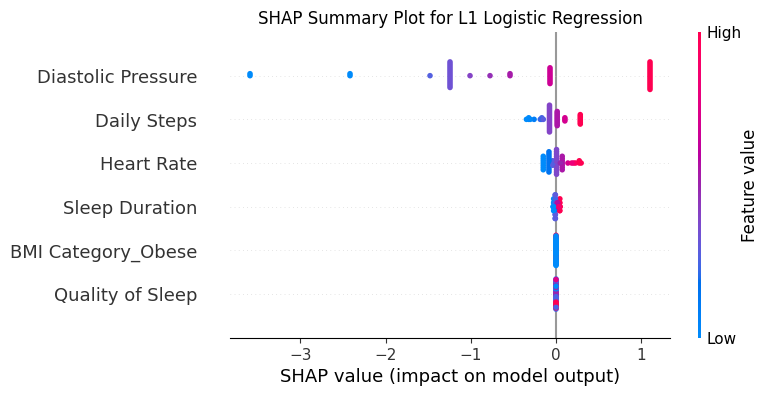

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP for L1 Logistic Regression Model
print("\n--- SHAP for L1 Logistic Regression Model ---")
# For linear models like Logistic Regression, LinearExplainer is appropriate
explainer_lr_l1 = shap.LinearExplainer(best_lr_l1_model, X_train_selected_std)
shap_values_lr_l1 = explainer_lr_l1.shap_values(X_test_selected_std)

# Visualize the SHAP summary plot with the *correctly filtered* SHAP values and feature names
# best_lr_l1_model is a binary classifier, so shap_values_lr_l1 is usually a 2D array (samples, features)
# If it were multi-class, it would be a list of arrays, one per class.
# Given current context (Sleep Apnea vs Insomnia), it's binary, so direct use is fine.

# If it's a list (for multi-class, where each element is an array of shap values for a class)
if isinstance(shap_values_lr_l1, list):
    # Plotting the first class for multi-class explanation
    shap.summary_plot(shap_values_lr_l1[0], X_test_selected_std, feature_names=selected_feature_names, show=False)
else:
    # For binary classification or single output, shap_values_lr_l1 is a 2D array
    shap.summary_plot(shap_values_lr_l1, X_test_selected_std, feature_names=selected_feature_names, show=False)

plt.title('SHAP Summary Plot for L1 Logistic Regression')
plt.show()


--- SHAP for Decision Tree Model ---
Shape of X_test_selected_std for Decision Tree SHAP (input to shap_values): (47, 6)


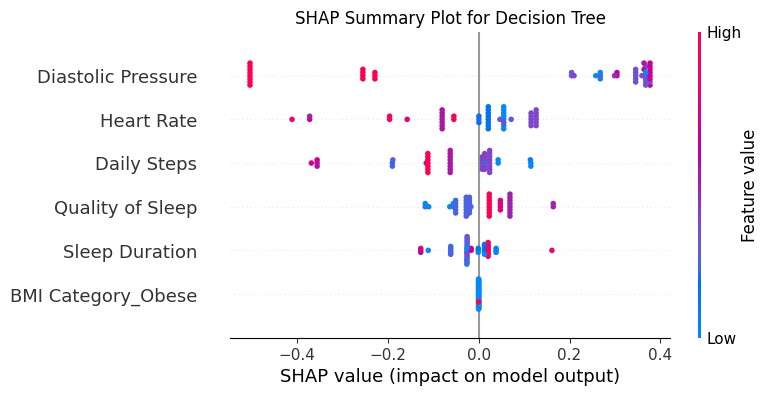

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP for Decision Tree Model
print("\n--- SHAP for Decision Tree Model ---")
# For tree-based models, TreeExplainer is appropriate
explainer_dt = shap.TreeExplainer(best_dt_model)

# X_test_selected_std has 6 features, which is what the model was trained on.
# So we can directly calculate SHAP values.
print(f"Shape of X_test_selected_std for Decision Tree SHAP (input to shap_values): {X_test_selected_std.shape}")

# Calculate SHAP values for all 6 features that the model was trained on.
shap_values_dt = explainer_dt.shap_values(X_test_selected_std)

# Visualize the SHAP summary plot with the correct SHAP values and feature names
# For binary classification with DecisionTreeClassifier, shap_values_dt is typically a list of two arrays,
# one for each class. We plot the first class (index 0).
if isinstance(shap_values_dt, list):
    # Plotting the first class for multi-class explanation
    shap.summary_plot(shap_values_dt[0], X_test_selected_std, feature_names=selected_feature_names, show=False)
else:
    # If it's a 3D array (samples, features, classes), select the first class as per instructions.
    # This covers cases where TreeExplainer might directly output a 3D array instead of a list for binary.
    shap.summary_plot(shap_values_dt[:, :, 0], X_test_selected_std, feature_names=selected_feature_names, show=False)

plt.title('SHAP Summary Plot for Decision Tree')
plt.show()


--- SHAP for Random Forest Model ---


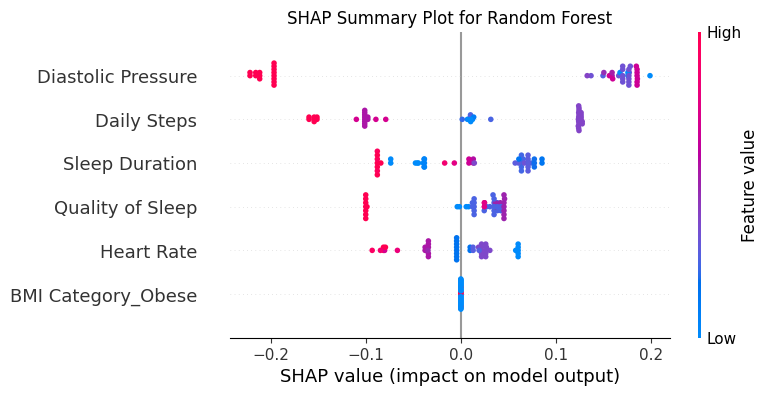

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP for Random Forest Model
print("\n--- SHAP for Random Forest Model ---")
# For tree-based models, TreeExplainer is appropriate
explainer_rf = shap.TreeExplainer(best_rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_selected_std)

# Visualize the SHAP summary plot with the 6 selected feature names
# For binary classification with RandomForestClassifier, shap_values_rf is typically a list of two arrays,
# one for each class. We plot the first class (index 0).
if isinstance(shap_values_rf, list):
    # For multi-output/multi-class (list of arrays), plot the first class
    shap.summary_plot(shap_values_rf[0], X_test_selected_std, feature_names=selected_feature_names, show=False)
elif hasattr(shap_values_rf, 'ndim') and shap_values_rf.ndim == 3:
    # If it's a 3D array (samples, features, classes), select the first class
    shap.summary_plot(shap_values_rf[:, :, 0], X_test_selected_std, feature_names=selected_feature_names, show=False)
elif hasattr(shap_values_rf, 'ndim') and shap_values_rf.ndim == 2 and shap_values_rf.shape[0] == X_test_selected_std.shape[0] and shap_values_rf.shape[1] == len(selected_feature_names):
    # For binary (or single output) as a 2D array, plot directly
    shap.summary_plot(shap_values_rf, X_test_selected_std, feature_names=selected_feature_names, show=False)
else:
    print("Warning: shap_values_rf has unexpected dimensions. Attempting to plot without explicit filtering.")
    shap.summary_plot(shap_values_rf, X_test_selected_std, feature_names=selected_feature_names, show=False)

plt.title('SHAP Summary Plot for Random Forest')
plt.show()


--- SHAP for SGDClassifier Model ---
X_test_selected_encoded_std shape: (47, 6)


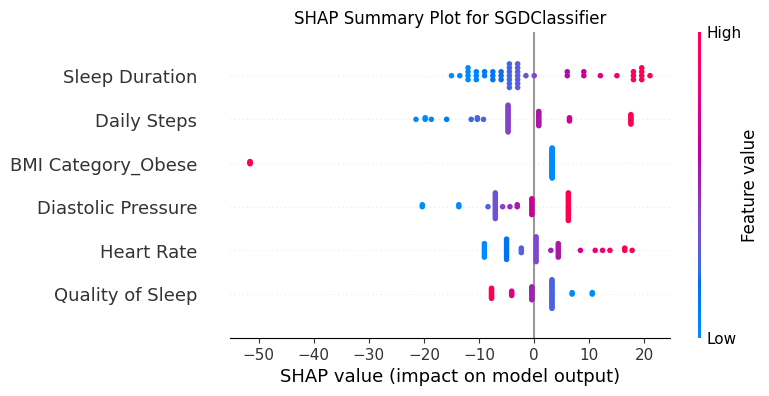

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP for SGDClassifier Model
print("\n--- SHAP for SGDClassifier Model ---")
# For SGDClassifier, LinearExplainer is appropriate
explainer_sgd = shap.LinearExplainer(best_sgd_model, X_train_selected_encoded_std)
shap_values_sgd = explainer_sgd.shap_values(X_test_selected_encoded_std)

print(f"X_test_selected_encoded_std shape: {X_test_selected_encoded_std.shape}")

# Visualize the SHAP summary plot with the 6 selected feature names
# For binary classification with SGDClassifier (linear model), shap_values_sgd is typically a 2D array.
shap.summary_plot(shap_values_sgd, X_test_selected_encoded_std, feature_names=selected_feature_names, show=False)

plt.title('SHAP Summary Plot for SGDClassifier')
plt.show()